In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

from osgeo import gdal    ## used to read images in memory

import tensorflow as tf

################################################################
## Storing and timing Models
import pickle
from joblib import dump,load
import time

################################################################
# Custom functions from lib.py
from lib import dataExtract, dataStack, indicesFromDataStack, \
                stochasticPCAFromDataStack, stochasticICAFromDataStack, \
                stackToImage, featuresCompute

################################################################
import warnings
warnings.filterwarnings("ignore")

################################################################

### Extract Data

In [2]:
colNames = ['coastal','blue','green','yellow','red','red edge','near IR1', 'near IR2','AGL','CLS']
rawDataTrain = dataExtract(foldername='train')

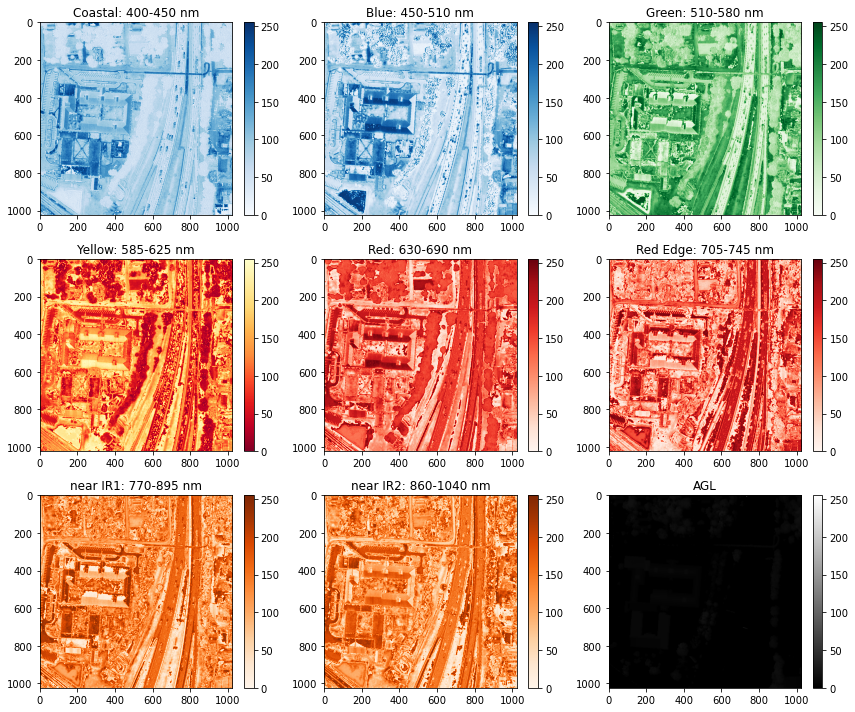

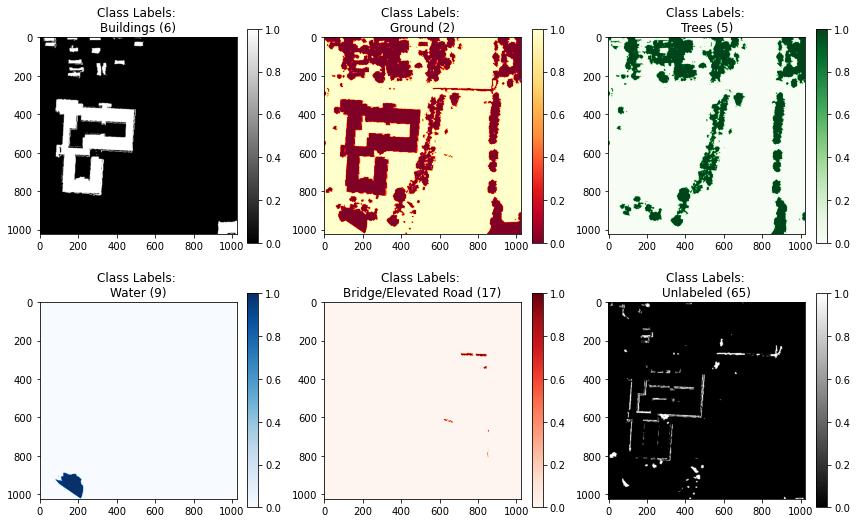

In [3]:
imgIdx = 2   ## index of image to plot

fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(12,10))
img = ax[0][0].imshow(rawDataTrain['MSI'][imgIdx][0].astype(np.uint8), cmap='Blues'); ax[0][0].set_title('Coastal: 400-450 nm'); fig.colorbar(img, ax=ax[0][0], fraction=0.05)
img = ax[0][1].imshow(rawDataTrain['MSI'][imgIdx][1].astype(np.uint8), cmap='Blues'); ax[0][1].set_title('Blue: 450-510 nm'); fig.colorbar(img, ax=ax[0][1], fraction=0.05)
img = ax[0][2].imshow(rawDataTrain['MSI'][imgIdx][2].astype(np.uint8), cmap='Greens'); ax[0][2].set_title('Green: 510-580 nm'); fig.colorbar(img, ax=ax[0][2], fraction=0.05)
img = ax[1][0].imshow(rawDataTrain['MSI'][imgIdx][3].astype(np.uint8), cmap='YlOrRd_r'); ax[1][0].set_title('Yellow: 585-625 nm'); fig.colorbar(img, ax=ax[1][0], fraction=0.05)
img = ax[1][1].imshow(rawDataTrain['MSI'][imgIdx][4].astype(np.uint8), cmap='Reds'); ax[1][1].set_title('Red: 630-690 nm'); fig.colorbar(img, ax=ax[1][1], fraction=0.05)
img = ax[1][2].imshow(rawDataTrain['MSI'][imgIdx][5].astype(np.uint8), cmap='Reds'); ax[1][2].set_title('Red Edge: 705-745 nm'); fig.colorbar(img, ax=ax[1][2], fraction=0.05)
img = ax[2][0].imshow(rawDataTrain['MSI'][imgIdx][6].astype(np.uint8), cmap='Oranges'); ax[2][0].set_title('near IR1: 770-895 nm'); fig.colorbar(img, ax=ax[2][0], fraction=0.05)
img = ax[2][1].imshow(rawDataTrain['MSI'][imgIdx][7].astype(np.uint8), cmap='Oranges'); ax[2][1].set_title('near IR2: 860-1040 nm'); fig.colorbar(img, ax=ax[2][1], fraction=0.05)
img = ax[2][2].imshow(rawDataTrain['AGL'][imgIdx].astype(np.uint8), cmap='gray'); ax[2][2].set_title('AGL'); fig.colorbar(img, ax=ax[2][2], fraction=0.05)

fig.tight_layout()
plt.savefig('./plots/rawData.svg')

fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(12,7.5))
img = ax[0][0].imshow((rawDataTrain['CLS'][imgIdx]==6).astype(np.uint8), cmap='gray'); ax[0][0].set_title('Class Labels: \nBuildings (6)'); fig.colorbar(img, ax=ax[0][0], fraction=0.05)
img = ax[0][1].imshow((rawDataTrain['CLS'][imgIdx]==2).astype(np.uint8), cmap='YlOrRd_r'); ax[0][1].set_title('Class Labels: \nGround (2)'); fig.colorbar(img, ax=ax[0][1], fraction=0.05)
img = ax[0][2].imshow((rawDataTrain['CLS'][imgIdx]==5).astype(np.uint8), cmap='Greens'); ax[0][2].set_title('Class Labels: \nTrees (5)'); fig.colorbar(img, ax=ax[0][2], fraction=0.05)
img = ax[1][0].imshow((rawDataTrain['CLS'][imgIdx]==9).astype(np.uint8), cmap='Blues'); ax[1][0].set_title('Class Labels: \nWater (9)'); fig.colorbar(img, ax=ax[1][0], fraction=0.05)
img = ax[1][1].imshow((rawDataTrain['CLS'][imgIdx]==17).astype(np.uint8), cmap='Reds'); ax[1][1].set_title('Class Labels: \nBridge/Elevated Road (17)'); fig.colorbar(img, ax=ax[1][1], fraction=0.05)
img = ax[1][2].imshow((rawDataTrain['CLS'][imgIdx]==65).astype(np.uint8), cmap='gray'); ax[1][2].set_title('Class Labels: \nUnlabeled (65)'); fig.colorbar(img, ax=ax[1][2], fraction=0.05)

fig.tight_layout()
plt.savefig('./plots/rawDataCLS.svg')

plt.show()

## Features Compute

In [4]:
dataTrain = dataStack(rawDataTrain)
## Compute features
dataTrain = pd.DataFrame( np.array(dataTrain) , columns=colNames )
dataTrain = featuresCompute(dataTrain, numPCA=3, numICA=3 )
print(f'Feature Names:\n{dataTrain.columns}')

Computed Principal Components
Computed Independent Components
	Computed NDVI: Normalized Difference Vegetation Index
	Computed NDWI: Normalized Difference Water Index
	Computed BAI: Burned Area Index
	Computed BNDVI: Blue Normalized Difference Vegetation Index
	Computed CVI: Chlorophyll Vegetation Index
	Computed GNDVI: Green Normalized Difference Vegetation Index
	Computed YNDVI: Yellow Normalized Difference Vegetation Index
	Computed OSAVI: Optimized Soil-Adjusted Vegetation Index
Computed Indices
Feature Names:
Index(['coastal', 'blue', 'green', 'yellow', 'red', 'red edge', 'near IR1',
       'near IR2', 'AGL', 'PC0', 'PC1', 'PC2', 'IC0', 'IC1', 'IC2',
       'ndvi_NIR1', 'ndvi_NIR2', 'ndwi_NIR1', 'ndwi_NIR2', 'bai_NIR1',
       'bai_NIR2', 'bndvi_NIR1', 'bndvi_NIR2', 'cvi_NIR1', 'cvi_NIR2',
       'gndvi_NIR1', 'gndvi_NIR2', 'yndvi_NIR1', 'yndvi_NIR2', 'osavi_NIR1',
       'osavi_NIR2', 'CLS'],
      dtype='object')


## Options:
- Use best classifier from HW2, get labels and segment
- Ignore best classifier from HW2, use ground truth labels as target, segment usin U-Net or R-CNN

In [5]:
del rawDataTrain

In [6]:
YTrain = dataTrain[dataTrain.columns[-1]]
dataTrain = dataTrain.drop(columns=dataTrain.columns[-1])

In [7]:
randomNumbers = np.random.permutation(len(dataTrain))[0:100000]
XTrain = dataTrain.iloc[randomNumbers]
YTrain = YTrain.iloc[randomNumbers]

from sklearn.ensemble import RandomForestClassifier

classifiers = [('Random Forest', RandomForestClassifier(n_estimators=100,criterion='entropy',
                                                        min_samples_split=200,min_samples_leaf=50,
                                                        bootstrap=True) ) ] 

## Train All Classifiers
for idx,clfTuple in enumerate(classifiers):
    print('\n##########################################################################\n')
    name = clfTuple[0]
    clf = clfTuple[1]
    print('{}:\n\t{}'.format(name,clf))
    
    # Train Classifier
    start = time.time()
    clf.fit(XTrain,YTrain)
    end = time.time()
    print('\tTraining time: {} seconds'.format(end-start))
    
    dump(clf,'./finalClassifiers/clf{}.joblib'.format(name))   ## store classifier for future use
    
    # Predictions and score on training set
    predictionsTrain = clf.predict(XTrain)
    scoreTrain = clf.score(XTrain,YTrain)

    print('Score [training set]: {}'.format(scoreTrain))


##########################################################################

Random Forest:
	RandomForestClassifier(criterion='entropy', min_samples_leaf=50,
                       min_samples_split=200)
	Training time: 80.75799798965454 seconds
Score [training set]: 0.89802


## Test Model

In [8]:
del dataTrain, XTrain, YTrain
rawDataTest = dataExtract(foldername='test2_assignment_2_sim')
dataTest = pd.DataFrame(dataStack(rawDataTest) , columns=colNames)
del rawDataTest
## Compute features
dataTest = featuresCompute(dataTest, numPCA=3, numICA=3 )
dataTest = dataTest.fillna(0)
YTest = dataTest[dataTest.columns[-1]]
XTest = dataTest.drop(columns=dataTest.columns[-1])
del dataTest

Computed Principal Components
Computed Independent Components
	Computed NDVI: Normalized Difference Vegetation Index
	Computed NDWI: Normalized Difference Water Index
	Computed BAI: Burned Area Index
	Computed BNDVI: Blue Normalized Difference Vegetation Index
	Computed CVI: Chlorophyll Vegetation Index
	Computed GNDVI: Green Normalized Difference Vegetation Index
	Computed YNDVI: Yellow Normalized Difference Vegetation Index
	Computed OSAVI: Optimized Soil-Adjusted Vegetation Index
Computed Indices


In [9]:
for idx,clfname in enumerate(os.listdir('./finalClassifiers')):
    name = clfname
    clf = load('./finalClassifiers/{}'.format(clfname))
    # Predictions and score on training set
    predictionsTest = clf.predict(XTest)
    scoreTest = clf.score(XTest,YTest)
    print('{}: Score [testing set]: {}'.format(name,scoreTest))
     

clfRandom Forest.joblib: Score [testing set]: 0.7462632179260253


Overall Accuracy: 0.746
User's Accuracy: [0.569   nan 0.776 0.795 0.544 0.127]
Producer's Accuracy: [0.77  0.    0.926 0.805 0.003 0.005]
Kappa Coefficient: 0.573

#################################################################



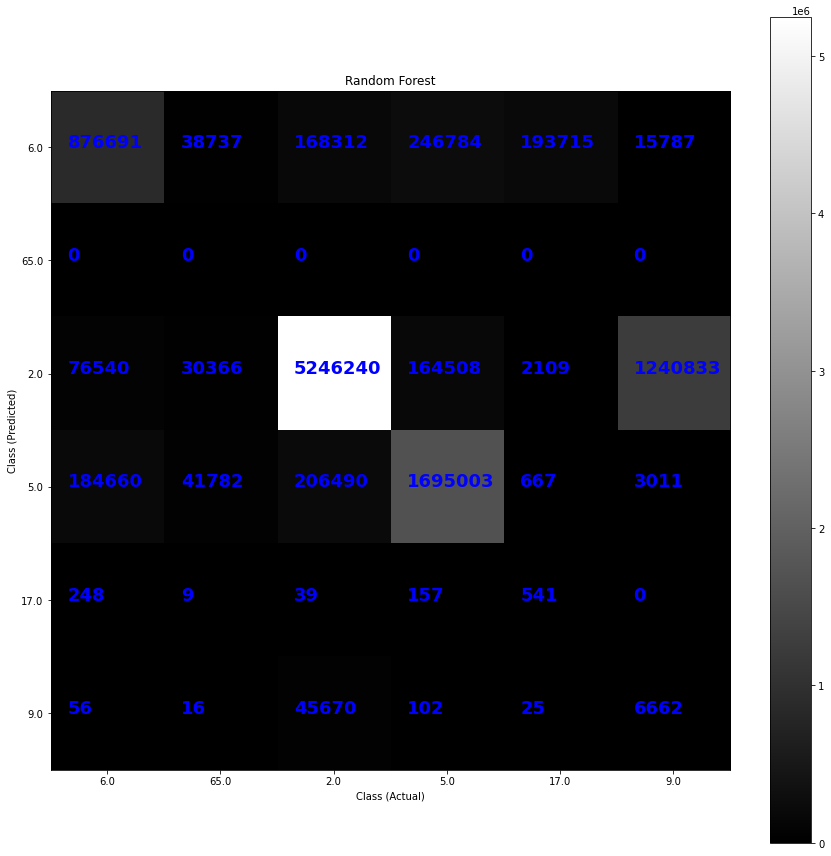

In [10]:
from lib import confusionMatrix, metrics, cMatrixPlots, vectorStackToImage
cMatrix = confusionMatrix(predictionsTest,YTest)

overallAccuracy, userAccuracy, producerAccuracy, kappaCoeff = metrics(cMatrix)
print('Overall Accuracy: {}'.format(np.round(overallAccuracy,3)))
print("User's Accuracy: {}".format(np.round(userAccuracy,3)))
print("Producer's Accuracy: {}".format(np.round(producerAccuracy,3)))
print('Kappa Coefficient: {}'.format(np.round(kappaCoeff,3)))
print('\n#################################################################\n')

cMatrixPlots(cMatrix,YTest,'Random Forest')
plt.show()

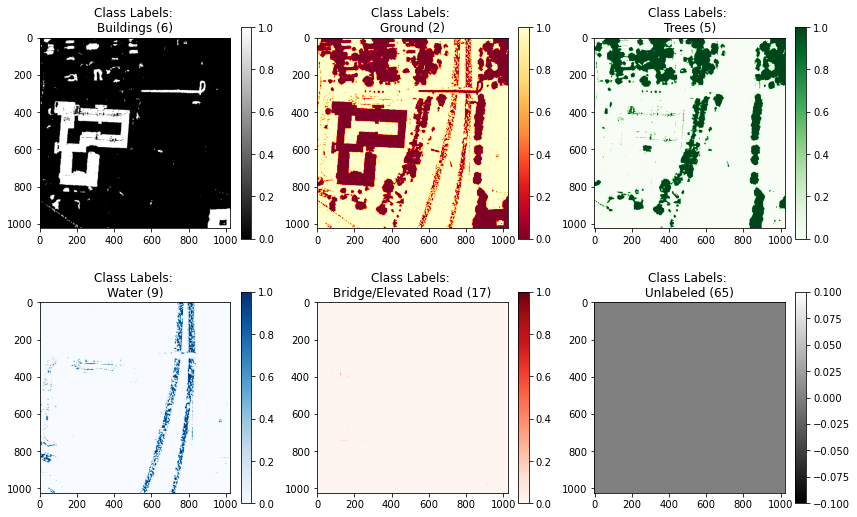

In [11]:
predictedClassImages = vectorStackToImage(pd.DataFrame(predictionsTest,columns=['CLS']),colNames=['CLS'])

imgIdx=1

fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(12,7.5))
img = ax[0][0].imshow((predictedClassImages['CLS'][imgIdx]==6).astype(np.uint8), cmap='gray'); ax[0][0].set_title('Class Labels: \nBuildings (6)'); fig.colorbar(img, ax=ax[0][0], fraction=0.05)
img = ax[0][1].imshow((predictedClassImages['CLS'][imgIdx]==2).astype(np.uint8), cmap='YlOrRd_r'); ax[0][1].set_title('Class Labels: \nGround (2)'); fig.colorbar(img, ax=ax[0][1], fraction=0.05)
img = ax[0][2].imshow((predictedClassImages['CLS'][imgIdx]==5).astype(np.uint8), cmap='Greens'); ax[0][2].set_title('Class Labels: \nTrees (5)'); fig.colorbar(img, ax=ax[0][2], fraction=0.05)
img = ax[1][0].imshow((predictedClassImages['CLS'][imgIdx]==9).astype(np.uint8), cmap='Blues'); ax[1][0].set_title('Class Labels: \nWater (9)'); fig.colorbar(img, ax=ax[1][0], fraction=0.05)
img = ax[1][1].imshow((predictedClassImages['CLS'][imgIdx]==17).astype(np.uint8), cmap='Reds'); ax[1][1].set_title('Class Labels: \nBridge/Elevated Road (17)'); fig.colorbar(img, ax=ax[1][1], fraction=0.05)
img = ax[1][2].imshow((predictedClassImages['CLS'][imgIdx]==65).astype(np.uint8), cmap='gray'); ax[1][2].set_title('Class Labels: \nUnlabeled (65)'); fig.colorbar(img, ax=ax[1][2], fraction=0.05)

fig.tight_layout()
plt.savefig('./plots/predictedCLS.svg')
plt.show()

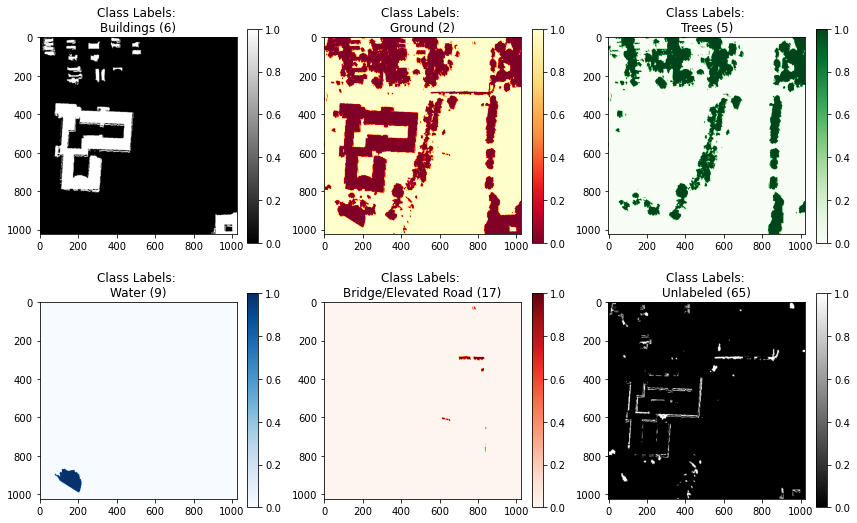

In [12]:
groundTruthTestClassImages = vectorStackToImage(pd.DataFrame(YTest,columns=['CLS']),colNames=['CLS'])

fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(12,7.5))
img = ax[0][0].imshow((groundTruthTestClassImages['CLS'][imgIdx]==6).astype(np.uint8), cmap='gray'); ax[0][0].set_title('Class Labels: \nBuildings (6)'); fig.colorbar(img, ax=ax[0][0], fraction=0.05)
img = ax[0][1].imshow((groundTruthTestClassImages['CLS'][imgIdx]==2).astype(np.uint8), cmap='YlOrRd_r'); ax[0][1].set_title('Class Labels: \nGround (2)'); fig.colorbar(img, ax=ax[0][1], fraction=0.05)
img = ax[0][2].imshow((groundTruthTestClassImages['CLS'][imgIdx]==5).astype(np.uint8), cmap='Greens'); ax[0][2].set_title('Class Labels: \nTrees (5)'); fig.colorbar(img, ax=ax[0][2], fraction=0.05)
img = ax[1][0].imshow((groundTruthTestClassImages['CLS'][imgIdx]==9).astype(np.uint8), cmap='Blues'); ax[1][0].set_title('Class Labels: \nWater (9)'); fig.colorbar(img, ax=ax[1][0], fraction=0.05)
img = ax[1][1].imshow((groundTruthTestClassImages['CLS'][imgIdx]==17).astype(np.uint8), cmap='Reds'); ax[1][1].set_title('Class Labels: \nBridge/Elevated Road (17)'); fig.colorbar(img, ax=ax[1][1], fraction=0.05)
img = ax[1][2].imshow((groundTruthTestClassImages['CLS'][imgIdx]==65).astype(np.uint8), cmap='gray'); ax[1][2].set_title('Class Labels: \nUnlabeled (65)'); fig.colorbar(img, ax=ax[1][2], fraction=0.05)

fig.tight_layout()
plt.savefig('./plots/groundTruthTestCLS.svg')
plt.show()